# Определение стоимости автомобилей

Целью проекта является построение модели машинного обучения, предсказывающей рыночную стоимость автомобиля. Заказчиком проекта является сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывающий приложение для привлечения новых клиентов.

Для построения модели машинного обучения предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей.

Критерии оценки модели, определенные заказчиком,  являются качество предсказания, скорость предсказания и время обучения. Для оценки качества моделей условием проекта определена метрика RMSE, значение которой должно  быть меньше 2500.

В соответствии с условием проекта мы построим несколько моделей машинного обучения, в том числе модели градиентного бустинга, включая модель средствами библиотеки библиотеку LightGBM. Выберем лучшую модель, которую протестируем на тестовой выборке.

На основе исследований сделаем выводу по предложению заказчику.

## Подготовка данных

Импортируем библиотеки, включая lightgbm и catboost, необходимые для построения моделей градиентного бустинга.

In [539]:
import pandas as pd
import numpy as np

from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error 
import category_encoders as ce

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import catboost as ctb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

Читаем содержимое файла /datasets/autos.csv и выводим типы данных колонок

In [540]:
try:

    data = pd.read_csv('C:\\Users\\User\\Downloads\\autos.csv')
    
except:

    data = pd.read_csv('/datasets/autos.csv')    

In [541]:
display(data.head(5))
print('')
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

### Предварительная обработка данных

Проверяем наличие пропусков 

In [542]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В столбцах 'VehicleType', 'Gearbox','Model', 'FuelType','Repaired' содержится много пропущенных значений. Прежде чем приступать к работе по их замене, определимся с набором данных, необходимых для построения модели машинного обучения.

Целевым признаком является 'Price' - цена автомобиля, исключим данные, которые для ее определения являются неинформативными:

'DateCrawled' - дата скачивания анкеты из базы и 'DateCreated' - дата создания анкеты характеризуют хронологию продажи автомобиля и являются информативными данными, а не ценообразующими;

'RegistrationMonth' - месяц регистрации автомобиля не имеет значения для его цены, так как при покупке-продаже автомобиля принимается во внимание год его регистрации, который у нас есть в столбце 'RegistrationYear';

'PostalCode' - почтовый индекс владельца анкеты (пользователя) и 'LastSeen' - дата последней активности пользователя дают представление о лице, продающем автомобиль. Иногда информация о продавце может сыграть большую роль в установлении цены автомобиля, но не указанная в этих столбцах. Почтовый индекс интересен только с точки зрения скорости связи с продавцом, дата активности показывает заинтересованность в продаже. Оба фактора не имеют реального влияния на цену;

'NumberOfPictures' - количество фотографий автомобиля может привлечь больше потенциальных покупателей, но автомобиль покупают не по фотографиям, а значит наличие их, количество или отсутствие на цене не скажутся.

По вышеуказанным причинам для построения модели машинного обучения исключим указанные параметры из исходного датасета, создав новый датафрейм.

In [543]:
autos = data.drop(['DateCrawled', 'DateCreated', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

display(autos.head(5))
print('')
autos.info()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Мы получили набор данных, представленный  354369 объектами, целевым признаком 'Price' и 10 признаками, 6 из которых типа 'object' и 4 - 'int64'.

Проведем исследование данных.

Выведем основные описательные статистики числовых признаков и проанализируем каждый из них.

In [544]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


##### 'Price' — цена автомодиля (в евро)

Price   [    0     1     2 ... 19998 19999 20000]


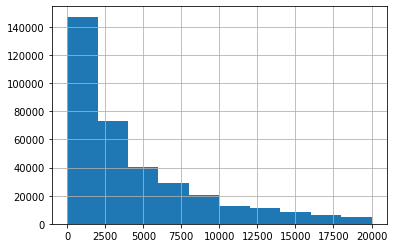

In [545]:
print('Price  ', autos ['Price'].sort_values().unique())
ax = autos ['Price'].hist()

In [546]:
print('В целевом признаке "Price"',autos.query('Price == 0')['Price'].count(), 'объектов имеют значение 0.') 
print('Доля нулевых значений целевого признака составляет', round(autos.query('Price == 0')['Price'].count()/
                                                                  autos['Price'].count()*100),'%')     

В целевом признаке "Price" 10772 объектов имеют значение 0.
Доля нулевых значений целевого признака составляет 3 %


В целевом признаке 'Price' исходного датафрейма data (как и созданного autos) пропусков не было. Однако имеется 10772 объекта, в которых цена автомобиля составляет 0 евро, что противоестественно для рынка.  Их доля составляет 3% от от набора данных, что позволяет их удалить.


Ограничиваем начальную цену автомобиля в 100 евро. По российскому курсу это около 8 тыс. руб., что даже для нашего рынка символично. Но на каждый товар есть свой покупатель и за эту цену продаются автомобили, которые не только продаются на запчасти, но и восстанавливаются любителями.
</div>

In [547]:
autos = autos.query('Price >= 100').reset_index(drop=True)
print('Price  ', autos ['Price'].sort_values().unique())

Price   [  100   101   105 ... 19998 19999 20000]


##### 'RegistrationYear' - год регистрации автомобиля

In [548]:
print('RegistrationYear  ', autos ['RegistrationYear'].sort_values().unique())

RegistrationYear   [1000 1001 1039 1111 1234 1255 1300 1400 1500 1600 1602 1800 1910 1923
 1925 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1940
 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954
 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968
 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2066 2200 2222 2290 2500
 2800 2900 3000 3200 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600
 5900 5911 6000 7000 7100 7800 8200 8500 8888 9000 9450 9999]


Посмотрим максимальную дату скачивания анкеты из базы.
</div>

In [549]:
pd.to_datetime(data['DateCrawled']).max()

Timestamp('2016-04-07 14:36:58')

Маскимальная дата скачивания анкеты из базы ограничена 2016 годом, значит все значения по столбцу "RegistrationYear" после этого года считаются аномальными, в связи с чем верхний порог года регистрации ограничим 2016 годом.
</div>

In [550]:
print('Аномальных значений по столбцу "RegistrationYear"',autos.query('RegistrationYear < 1910')['RegistrationYear'].count(
)+ autos.query('RegistrationYear >2016')['RegistrationYear'].count())

Аномальных значений по столбцу "RegistrationYear" 13730


В столбце "RegistrationYear" имеется 13730 значений года регистрации автомобиля 1800 год и ранее и 2017 год и позднее, что является явной аномалией, которую необходимо устранить 

In [551]:
autos = autos.query('1910 <= RegistrationYear <= 2016').reset_index(drop=True)
print('RegistrationYear  ', autos ['RegistrationYear'].sort_values().unique())

RegistrationYear   [1910 1923 1925 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937
 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952
 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016]


Аномальные значения по столбцу "RegistrationYear" устранены. Диапазон года регистрации автомобиля находится в значениях 1910 - 2019 годы, что соответствует естественным временным рамкам.

##### 'Power' - мощность (л. с.)

In [552]:
print('Power ', autos ['Power'].sort_values().unique())

Power  [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158   159   160   161   162  

Машины с мощностью от 0 до 10 л.с. могут иметь место при отсутствии двигателя, его неисправности, либо сильной изношенности, но тем не менее присутствовать на рынке продаж и находить своего покупателя, а вот автомобили мощностью более 400 л.с. - явный выброс в данных, который подлежит устранению.
    </div>

In [553]:
autos = autos.query('Power <= 400').reset_index(drop=True)
autos['Power'].describe()

count    326673.000000
mean        108.621288
std          61.369829
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max         400.000000
Name: Power, dtype: float64

Аномалии и выбросы по столбцу "Power" устранены.

##### 'Kilometer' - пробег (км)

[  5000  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 125000 150000]


count    326673.000000
mean     128362.169509
std       37244.446795
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

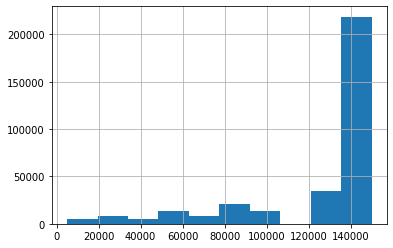

In [554]:
print(autos['Kilometer'].sort_values().unique())
autos['Kilometer'].hist()
autos['Kilometer'].describe()

Аномалий в признаке 'Kilometer' не выявлено, данные вполне реалистичны, оставляем их без измененя.

Мы обработали признаки, представленные числовыми данными, теперь изучим категориальные переменные, еще раз посмотрев на наличие пропусков в датасете.

In [555]:
autos.isna().sum()

Price                   0
VehicleType         18861
RegistrationYear        0
Gearbox             14577
Power                   0
Model               15112
Kilometer               0
FuelType            23033
Brand                   0
Repaired            58263
dtype: int64

С учетом удаления из отдельных столбцов аномальных зачений пропуски все еще остались по столбцам 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired'. Их замену осуществим методами, соответствующими информативности каждого признака.  
    

В столбцах 'VehicleType'— тип автомобильного кузова и 'FuelType' - тип топлива пропущенные значения заменим видами кузова и топлива, наиболее характерными для каждой модели автомобиля. 

Для этого создадим датафреймы, в которых в качестве индекса передадим тип кузова (тип топлива), столбцами станут модели автомобилей. Данные сгруппируем по количеству  моделей каждого вида с определенным типом кузова (использующим определенный вид топлива).  

После этого напишем функцию для замены пропущенного значения, в теле которой пропишем условие: тип кузова (топлива) определенной модели автомобиля, имеющий значение NaN, заменить индексом (типом кузова, топлива), в котором модель имеет максимальное значение. 

In [556]:
autos['VehicleType'].value_counts()# изучаем данные столбца 'VehicleType'

sedan          88862
small          77351
wagon          63327
bus            28238
convertible    19793
coupe          15507
suv            11703
other           3031
Name: VehicleType, dtype: int64

In [557]:
# Создаем датафрейм

autos_VehicleType = autos.pivot_table(index='VehicleType',columns='Brand',values='Price', aggfunc='count')
autos_VehicleType 

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,6.0,154.0,409.0,1247.0,50.0,26.0,34.0,817.0,...,610.0,231.0,1.0,184.0,17.0,27.0,446.0,NaN,9351.0,NaN
convertible,177.0,1610.0,3188.0,13.0,227.0,112.0,NaN,1.0,17.0,504.0,...,NaN,4.0,1124.0,319.0,1.0,35.0,63.0,36.0,2877.0,75.0
coupe,225.0,1459.0,3654.0,88.0,47.0,147.0,NaN,8.0,NaN,167.0,...,84.0,10.0,336.0,218.0,8.0,7.0,220.0,3.0,1708.0,67.0
other,13.0,105.0,218.0,43.0,9.0,111.0,6.0,4.0,10.0,178.0,...,62.0,26.0,8.0,206.0,5.0,13.0,18.0,5.0,714.0,5.0
sedan,904.0,10587.0,17123.0,222.0,273.0,686.0,100.0,104.0,47.0,873.0,...,1731.0,903.0,27.0,455.0,163.0,177.0,884.0,196.0,19231.0,633.0
small,233.0,1528.0,428.0,574.0,12.0,1554.0,221.0,265.0,501.0,5153.0,...,3040.0,1111.0,3227.0,236.0,114.0,958.0,1576.0,53.0,17839.0,7.0
suv,NaN,176.0,800.0,375.0,22.0,35.0,214.0,1.0,46.0,24.0,...,4.0,173.0,NaN,418.0,59.0,741.0,436.0,1.0,1305.0,219.0
wagon,448.0,10733.0,7711.0,105.0,240.0,613.0,250.0,44.0,16.0,435.0,...,385.0,2679.0,9.0,122.0,289.0,87.0,568.0,70.0,12321.0,1924.0


In [558]:
# Пишем функцию, проверяем замену пропусков в столбце 'VehicleType'

autos.fillna({'VehicleType':0},inplace=True)

def replacement(row, row_number, autos_VehicleType):
    brand = row[8]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = autos_VehicleType[brand].idxmax()
    return fill_value

autos['VehicleType'] = autos.apply(replacement, args=[1, autos_VehicleType], axis=1)
display(autos['VehicleType'].isna().sum())
autos['VehicleType'].value_counts()

0

sedan          97739
small          85600
wagon          64813
bus            28308
convertible    19825
coupe          15507
suv            11850
other           3031
Name: VehicleType, dtype: int64

Применим написанную функцию replacement для замены пропусков встолбце 'FuelType'

In [559]:
# изучаем данные столбца 'FuelType'

print('FuelType', autos['FuelType'].sort_values().unique())
print('Пропусков в столбце "FuelType":', autos['FuelType'].isna().sum())
autos['FuelType'].value_counts()

FuelType ['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan]
Пропусков в столбце "FuelType": 23033


petrol      203106
gasoline     94557
lpg           4999
cng            527
hybrid         219
other          147
electric        85
Name: FuelType, dtype: int64

In [560]:
# Создаем датафрейм, применяем функцию replacement к столбцу 'FuelType' и проверяем замену пропусков

autos.fillna({'FuelType':0},inplace=True)
autos_FuelType =  autos.pivot_table(index='FuelType',columns='Brand',values='Price', aggfunc='count')

autos['FuelType'] = autos.apply(replacement, args=[7, autos_FuelType], axis=1)
display(autos['FuelType'].isna().sum())
autos['FuelType'].value_counts()

0

petrol      226118
gasoline     94578
lpg           4999
cng            527
hybrid         219
other          147
electric        85
Name: FuelType, dtype: int64

In [561]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326673 entries, 0 to 326672
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             326673 non-null  int64 
 1   VehicleType       326673 non-null  object
 2   RegistrationYear  326673 non-null  int64 
 3   Gearbox           312096 non-null  object
 4   Power             326673 non-null  int64 
 5   Model             311561 non-null  object
 6   Kilometer         326673 non-null  int64 
 7   FuelType          326673 non-null  object
 8   Brand             326673 non-null  object
 9   Repaired          268410 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


##### 'Model'- модель автомобиля

In [562]:
print('Model', autos['Model'].sort_values().unique())

Model ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'impr

Пропуски в столбце 'Model' заменим на 'unknown'.

In [563]:
autos['Model'] = autos['Model'].fillna('unknown')
print('Пропусков в столбце "Model":', autos['Model'] .isna().sum())

Пропусков в столбце "Model": 0


Из столбца 'Model' также исключим модели, представленные в количестве, которое не подпадает под определение рынка автомобилей. На фоне более 300 тыс. объектов будем считать, что понятием рынок охватывается более 10 автомобилей определенной модели. Следуя этой логике исключим из исходных данных модели, представленные в количестве 10 и мньше машин. 

In [564]:
autos['Model'].value_counts().tail(20)

delta                 31
charade               26
b_max                 26
9000                  24
musa                  22
materia               18
200                   17
kappa                 14
q3                    13
gl                    12
amarok                12
samara                11
i3                     8
serie_2                7
elefantino             7
kalina                 6
rangerover             3
serie_3                3
range_rover_evoque     2
serie_1                1
Name: Model, dtype: int64

In [565]:
autos = autos.query('Model != "serie_2" and Model != "kalina" and Model != "samara"and Model != "i3" \
                     and Model != "rangerover" and Model != "serie_3" and Model != "range_rover_evoque"\
                     and Model != "amarok" and Model != "gl" and Model != "elefantino" and Model != "serie_1"').reset_index(drop=True)# 

##### 'Gearbox'— тип коробки передач

Проверяем пропуски в столбце 'Gearbox' и изучаем данные

In [566]:
print('Пропусков в столбце "Gearbox":', autos['Gearbox'] .isna().sum())
print('Gearbox', autos['Gearbox'].sort_values().unique())
print(autos['Gearbox'].value_counts())

Пропусков в столбце "Gearbox": 14576
Gearbox ['auto' 'manual' nan]
manual    249561
auto       62464
Name: Gearbox, dtype: int64


Подавляющее большинство автомобилей, выставленных на продажу имеют тип коробки передач 'manual', им и заменим пропущенные значения.

In [567]:
autos['Gearbox'] = autos['Gearbox'].fillna('manual')
print('Пропусков в столбце "Gearbox":', autos['Gearbox'] .isna().sum())
print('Gearbox', autos['Gearbox'].sort_values().unique())
print(autos['Gearbox'].value_counts())

Пропусков в столбце "Gearbox": 0
Gearbox ['auto' 'manual']
manual    264137
auto       62464
Name: Gearbox, dtype: int64


##### 'Repaired'— была машина в ремонте или нет

Проверяем пропуски в столбце 'Repaired' и изучаем данные

In [568]:
print('Пропусков в столбце "Repaired":', autos['Repaired'] .isna().sum())
print('Repaired', autos['Repaired'].sort_values().unique())
print(autos['Repaired'].value_counts())

Пропусков в столбце "Repaired": 58248
Repaired ['no' 'yes' nan]
no     236032
yes     32321
Name: Repaired, dtype: int64


Автомобилей, которые не ремонтировались, почти в десять раз больше тех, что были в ремонте. Пропущенные в столбце "Repaired" значения заменим показателем 'no'. 

In [569]:
autos['Repaired'] = autos['Repaired'].fillna('no')
print('Пропусков в столбце "Repaired":', autos['Repaired'] .isna().sum())
print('Repaired', autos['Repaired'].sort_values().unique())
print(autos['Repaired'].value_counts())

Пропусков в столбце "Repaired": 0
Repaired ['no' 'yes']
no     294280
yes     32321
Name: Repaired, dtype: int64


In [570]:
autos.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Пропуски в данных устранены

##### 'Brand' - марка автомобиля

In [571]:
print(autos['Brand'].sort_values().unique())

['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']


Аномалий по столбцу 'Brand' не выявлено, оставляем данные без изменения.

Проверяем наличие дубликатов

In [572]:
print("Полных дубликатов:", autos.duplicated().sum())

Полных дубликатов: 52671


В данных установлено полных 49165 дубликатов. Но в наших данных пропуски в категориальных значениях мы заменяли усередненными данными (по большинству, либо на  'unknown'), количественные характеристики также не являются эксклюзивными. Все это дает основание не исключать полные дубликаты. 

In [573]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326601 entries, 0 to 326600
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             326601 non-null  int64 
 1   VehicleType       326601 non-null  object
 2   RegistrationYear  326601 non-null  int64 
 3   Gearbox           326601 non-null  object
 4   Power             326601 non-null  int64 
 5   Model             326601 non-null  object
 6   Kilometer         326601 non-null  int64 
 7   FuelType          326601 non-null  object
 8   Brand             326601 non-null  object
 9   Repaired          326601 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


После предварительной обработки данных у нас осталось 326601 объект. Изучим корреляцию количественных признаков, в первую очередь целевого признака по отношению к остальным.

Имеется логичная положительная корреляция между ценой и мощьностью автомобиля, ценой и годом регистрации: чем больше мощьность и позднее год регистрации - тем дороже автомобиль. Также вполне логична отрицательная корреляция между ценой и пробегом автомобиля.

In [574]:
autos.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.442081,0.489000,-0.365253
RegistrationYear,0.442081,1.000000,0.155019,-0.227979
Power,0.489000,0.155019,1.000000,0.078918
Kilometer,-0.365253,-0.227979,0.078918,1.000000


 <b>Вывод:</b>Мы провели предварительную обработку данных, которая заключалась в следующем: 

устранены аномальные значения в столбцах 'Price', 'RegistrationYear' и 'Power'; 

пропущенные значения  в столбцах 'VehicleType' и 'FuelType' заменены на типы, используемые в большинстве случаев каждой конкретной моделью автомобиля;

пропуски в столбцах  'Repaired' и 'Gearbox', имеющих бинарные значения,  заменены на значения, представленные в большинстве;

пропуски по столбцу 'Model' заменили на 'unknown'.
    
Изучением корреляции количественных признаков установлена логичная положительная корреляция между ценой и мощьностью автомобиля и отрицательная корреляция между ценой и пробегом автомобиля.    

### Подготовка признаков для обучения моделей

В наборе данных, которые мы обработали для построения модели машинного обучения, 6 категориальных признаков. Для построения модели машинного обучения эти признаки необходимо перевести в количественные. Признаки 'Gearbox' и 'Repaired' содержат всего по два значения. Чтоб минимизировать количество данных, на которых будет обучаться модель, для преобразования 'Gearbox' и 'Repaired' в количественные переменные напишем функцию, которая и категоризирует.   

In [575]:
def change(row):
    if (row == 'auto'
    or row == 'no'):     
        return 0
    if (row == 'manual'
    or row == 'yes'):   
        return 1
autos['Gearbox'] = autos['Gearbox'].apply(change)  
autos['Repaired'] = autos['Repaired'].apply(change)  
print(autos['Gearbox'].value_counts())
print('')
print(autos['Repaired'].value_counts())
autos.head()

1    264137
0     62464
Name: Gearbox, dtype: int64

0    294280
1     32321
Name: Repaired, dtype: int64


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,1,0,golf,150000,petrol,volkswagen,0
1,18300,coupe,2011,1,190,unknown,125000,gasoline,audi,1
2,9800,suv,2004,0,163,grand,125000,gasoline,jeep,0
3,1500,small,2001,1,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,1,69,fabia,90000,gasoline,skoda,0


Категоризируем данные столбца 'RegistrationYear'. При этом будем исходить из следующего:
    
стоимость автомобиля на уровне его начальной цены держится примерно первые 5 лет с начала эксплуатации, после чего автомобиль сильно дешевеет, следующая категория стоимости - машина от 5 до 10 лет, делее - от 10 до 20 лет и более 20 лет.
    
При этом, если отталкиваться от российского законодательства, то по существующему госту ГОСТР 586886 2019 года раритетные автомобили делятся на категории: выпущенные до 1946 года, в период с 1946 по 1970, с 1970 года.
    
В зависимости от этих критериев и категоризируем значения столбца 'RegistrationYear', для чено напишем функцию.
</div>

In [576]:
def RegistrationYear(row):
    if row <= 1945:
         return 0
    if 1946 <= row <= 1970:
        return 1
    if 1971 <=row <= 1996:
        return 2     
    if 1997 <= row <= 2006:
        return 3   
    if  2007 <= row <= 2011:
        return 4  
    if 2012 <= row <= 2016:
        return 5  
autos['RegistrationYear'] = autos['RegistrationYear'].apply(RegistrationYear)  
autos['RegistrationYear'].value_counts()

3    192940
4     66906
2     41791
5     23645
1      1225
0        94
Name: RegistrationYear, dtype: int64

In [577]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326601 entries, 0 to 326600
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             326601 non-null  int64 
 1   VehicleType       326601 non-null  object
 2   RegistrationYear  326601 non-null  int64 
 3   Gearbox           326601 non-null  int64 
 4   Power             326601 non-null  int64 
 5   Model             326601 non-null  object
 6   Kilometer         326601 non-null  int64 
 7   FuelType          326601 non-null  object
 8   Brand             326601 non-null  object
 9   Repaired          326601 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 24.9+ MB


Выделяем признаки и целевой признак

In [578]:
features=autos.drop('Price',axis=1) # Признаки
target=autos['Price']
display(features.head())
print(target.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,sedan,2,1,0,golf,150000,petrol,volkswagen,0
1,coupe,4,1,190,unknown,125000,gasoline,audi,1
2,suv,3,0,163,grand,125000,gasoline,jeep,0
3,small,3,1,75,golf,150000,petrol,volkswagen,0
4,small,4,1,69,fabia,90000,gasoline,skoda,0


0      480
1    18300
2     9800
3     1500
4     3600
Name: Price, dtype: int64


В соответствии с условием проекта необходимо построить модели машинного обучения, выбрать лучшую из них в соответсвии с критериями заказчика и протестировать работу на тестовой выборке.

В этой связи разделим данные на обучающую, валидационную (для обучения проверки качества) и тестовую выборки (для тестирования лучшей модели) в соотношении 3:1:1.

In [579]:
STATE = RandomState(12345)

train_features, test_features, train_target, test_target = train_test_split(features, target, 
                                                    train_size=0.6,  
                                                    random_state=STATE,
                                                    shuffle=True)

test_features, valid_features, test_target, valid_target = train_test_split(test_features, test_target, 
                                                    train_size=0.5, 
                                                    random_state=STATE,
                                                    shuffle=True)

print('Размеры выборок:')
print('train_features',train_features.shape)
print('valid_features', valid_features.shape)
print('test_features', test_features.shape)
print('train_target', train_target.shape)
print('valid_target', valid_target.shape)
print('test_target', test_target.shape)

Размеры выборок:
train_features (195960, 9)
valid_features (65321, 9)
test_features (65320, 9)
train_target (195960,)
valid_target (65321,)
test_target (65320,)


По условию проекта необходимо построить модели машинного обучения, в числе которых модели градиентного бустинга. Использование библиотек lightgbm и catboost позволяет для обучения передавать категориальные признаки. Чтоб построить одну из моделей с использованием этой возможности сохраним не кодированные и не стандартизированные признаки по каждой выборке в самосточтельных переменных.

In [580]:
original_train_features = train_features
original_valid_features = valid_features
original_test_features = test_features

Кодирование признаков

В данных осталось четыре категориальных признака 'VehicleType', 'Model','FuelType' и 'Brand' для пребразования которых применим целевое кодирование из category_encoders отдельно по каждой выборке. Перед этим проверим количественное соответствие значений каждого признака во всех выборках.

In [581]:
print(len(train_features['VehicleType'].sort_values().unique()))
print(len(valid_features['VehicleType'].sort_values().unique()))
print(len(test_features['VehicleType'].sort_values().unique()))
print('')
print(len(train_features['Model'].sort_values().unique()))
print(len(valid_features['Model'].sort_values().unique()))
print(len(test_features['Model'].sort_values().unique()))
print('')
print(len(train_features['FuelType'].sort_values().unique()))
print(len(valid_features['FuelType'].sort_values().unique()))
print(len(test_features['FuelType'].sort_values().unique()))
print('')
print(len(train_features['Brand'].sort_values().unique()))
print(len(valid_features['Brand'].sort_values().unique()))
print(len(test_features['Brand'].sort_values().unique()))
print('')

8
8
8

240
240
240

7
7
7

40
40
40



К категориальным признакам применяем целевое кодирование путем передачи TargetEncoder целевого признака train_target.
    


In [583]:
encoder = ce.TargetEncoder(return_df=True)
train_features = encoder.fit_transform(train_features, train_target)
train_features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
108468,5529.285748,3,1,120,3994.347656,150000,6721.375283,2842.444022,0
133694,2660.588042,5,1,54,1454.685895,150000,3747.328730,2407.684735,0
315108,4954.041149,4,1,101,3391.189394,150000,3747.328730,2890.442750,0
38134,5529.285748,3,1,114,4533.832314,150000,6721.375283,2407.684735,0
182659,2660.588042,3,1,50,1127.111562,150000,3747.328730,4185.158856,0
...,...,...,...,...,...,...,...,...,...
158838,4954.041149,4,1,95,3261.538156,80000,3747.328730,3217.085417,1
47873,4619.429939,3,1,55,4366.703195,150000,3747.328730,4590.765657,0
86398,4954.041149,3,1,131,5976.458532,150000,6721.375283,6471.828075,0
77285,2660.588042,3,1,75,2680.294325,150000,3747.328730,4590.765657,0


In [584]:
valid_features = encoder.transform(valid_features)
valid_features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
167006,5529.285748,3,1,69,3253.205882,150000,6721.375283,3584.965261,0
117180,4619.429939,3,1,105,6355.764637,150000,6721.375283,6471.828075,0
319352,2660.588042,3,1,50,1463.826268,150000,3747.328730,4590.765657,0
230835,4619.429939,2,0,90,4690.694581,150000,3747.328730,4590.765657,0
119874,2660.588042,4,1,177,7392.434292,50000,6721.375283,4878.924886,0
...,...,...,...,...,...,...,...,...,...
163427,2660.588042,4,0,68,1733.955801,50000,3747.328730,3217.085417,0
10174,4619.429939,4,1,110,7279.067625,150000,3747.328730,4590.765657,0
298179,2660.588042,4,1,54,2878.094170,60000,3747.328730,4590.765657,0
151428,5529.285748,3,1,1,6234.917633,125000,6721.375283,4590.765657,0


In [585]:
test_features = encoder.transform(test_features)
test_features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
297798,5529.285748,3,1,110,4533.832314,150000,6721.375283,3584.965261,0
6887,6966.268905,2,1,55,6273.648068,10000,3747.328730,4590.765657,0
173409,2660.588042,5,1,60,2011.609147,150000,3747.328730,2890.442750,0
56011,5529.285748,3,1,140,7279.067625,150000,6721.375283,4590.765657,0
255316,2660.588042,3,1,55,2011.609147,150000,3747.328730,2890.442750,0
...,...,...,...,...,...,...,...,...,...
144484,4954.041149,3,1,107,2274.476510,30000,3747.328730,2407.684735,0
134340,6226.762023,3,1,140,6355.764637,150000,6721.375283,6471.828075,0
39442,2660.588042,5,1,75,2668.539216,150000,3747.328730,3278.892496,0
199015,4619.429939,3,1,82,3481.856710,100000,3747.328730,6064.999614,0


 В связи с тем, что признак 'RegistrationYear' категоризирован, он исключен из числа стандартизируемых.
</div>

В признаках 'Power'и 'Kilometer' числовые значения различаются по масштабу, стандартизируем их посредством модуля StandardScaler.

In [590]:
n = ['Power', 'Kilometer']

scaler = StandardScaler()

scaler.fit(train_features[n]) 
train_features[n] = scaler.transform(train_features[n])
display(train_features.head(3))
train_features.info()

valid_features[n] = scaler.transform(valid_features[n])
display(valid_features.head(3))
valid_features.info()

test_features[n] = scaler.transform(test_features[n])
display(test_features.head(3))
test_features.info()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
108468,5529.285748,3,1,0.186661,3994.347656,0.581387,6721.375283,2842.444022,0
133694,2660.588042,5,1,-0.889148,1454.685895,0.581387,3747.328730,2407.684735,0
315108,4954.041149,4,1,-0.123041,3391.189394,0.581387,3747.328730,2890.442750,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 195960 entries, 108468 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       195960 non-null  float64
 1   RegistrationYear  195960 non-null  int64  
 2   Gearbox           195960 non-null  int64  
 3   Power             195960 non-null  float64
 4   Model             195960 non-null  float64
 5   Kilometer         195960 non-null  float64
 6   FuelType          195960 non-null  float64
 7   Brand             195960 non-null  float64
 8   Repaired          195960 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 15.0 MB


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
167006,5529.285748,3,1,-0.644646,3253.205882,0.581387,6721.375283,3584.965261,0
117180,4619.429939,3,1,-0.057841,6355.764637,0.581387,6721.375283,6471.828075,0
319352,2660.588042,3,1,-0.954348,1463.826268,0.581387,3747.328730,4590.765657,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65321 entries, 167006 to 112892
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VehicleType       65321 non-null  float64
 1   RegistrationYear  65321 non-null  int64  
 2   Gearbox           65321 non-null  int64  
 3   Power             65321 non-null  float64
 4   Model             65321 non-null  float64
 5   Kilometer         65321 non-null  float64
 6   FuelType          65321 non-null  float64
 7   Brand             65321 non-null  float64
 8   Repaired          65321 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 5.0 MB


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
297798,5529.285748,3,1,0.023660,4533.832314,0.581387,6721.375283,3584.965261,0
6887,6966.268905,2,1,-0.872848,6273.648068,-3.175348,3747.328730,4590.765657,0
173409,2660.588042,5,1,-0.791347,2011.609147,0.581387,3747.328730,2890.442750,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65320 entries, 297798 to 59641
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VehicleType       65320 non-null  float64
 1   RegistrationYear  65320 non-null  int64  
 2   Gearbox           65320 non-null  int64  
 3   Power             65320 non-null  float64
 4   Model             65320 non-null  float64
 5   Kilometer         65320 non-null  float64
 6   FuelType          65320 non-null  float64
 7   Brand             65320 non-null  float64
 8   Repaired          65320 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 5.0 MB


 <b>Вывод:</b> Мы разделили данные на учебную, валидационную и тестовую выборки в соотношении 3:1:1, провели подготовку признаков для построения моделей которая состояла в следующем:

категоризировали признаки 'Gearbox', 'Repaired' и 'RegistrationYear'; 
    
закодировали техникой  целевого кодирования признаки 'VehicleType', 'Model','FuelType','Brand';
    
стандартизировали посредством модуля StandardScaler признаки  'Power', 'Kilometer'. 
    

## Обучение моделей

В соответствии с условием проекта мы построим несколько моделей машинного обучения: 

Случайный лес и Дерево решений (при гиперпараметрах по умолчанию и с подборкой гиперпараметров с использованием GridSearchCV по каждой модели), 

модели градиентного бустинга LightGBM  также с гиперпараметрами по умолчанию и их подбором GridSearchCV,

модели градиентного бустинга CatBoost с гиперпараметрами по умолчанию на преобразованных признаках и с передачей категориальных признаков 'VehicleType', 'Model','FuelType','Brand' , которые остались в исходном состоянии в выборках, сохраненных в специальных переменных.

При обучении каждой модели и получении предсказаний мы измерим время выполнения ячейки кода методом %%time.

### Cлучайный лес

Построим модель Случайный лес при гиперпараметрах, за исключением random_state по умолчанию. 

In [591]:
%%time
forest_default = RandomForestRegressor(random_state= STATE)
forest_default.fit(train_features,train_target)

CPU times: total: 32.2 s
Wall time: 33.1 s


RandomForestRegressor(random_state=RandomState(MT19937) at 0x19E9C8D4C40)

In [592]:
%%time
prediction_forest_default = forest_default.predict(valid_features)

CPU times: total: 1.66 s
Wall time: 1.67 s


In [593]:
rmse_forest_default = round(mean_squared_error(valid_target, prediction_forest_default)**0.5)
rmse_forest_default

1812

Подберем для Случайного леса лучшие гиперпараметры

In [594]:
rf_params = {'n_estimators': [10, 20, 30, 40],
             'max_features': ['auto', 'sqrt'],
             'max_depth': [2,4,6,8],
             'min_samples_leaf': [1, 2, 3, 4],
             'random_state' : [12345]}
forest_model = GridSearchCV(RandomForestRegressor(random_state=12345
                                                 ),rf_params,scoring='neg_mean_squared_error', n_jobs=-1, cv = 3, verbose=2)
forest_model.fit(train_features,train_target)
forest_predictions = forest_model.predict(valid_features)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


In [595]:
print("Лучшие гиперпараметры для модели 'Случайный лес' установлены:",forest_model.best_params_)

Лучшие гиперпараметры для модели 'Случайный лес' установлены: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 40, 'random_state': 12345}


In [596]:
%%time
forest_best = RandomForestRegressor(random_state= STATE , max_depth=8, min_samples_leaf = 2, n_estimators = 40)
forest_best.fit(train_features,train_target)

CPU times: total: 7.38 s
Wall time: 7.5 s


RandomForestRegressor(max_depth=8, min_samples_leaf=2, n_estimators=40,
                      random_state=RandomState(MT19937) at 0x19E9C8D4C40)

In [597]:
%%time
prediction_forest_best = forest_best.predict(valid_features)

CPU times: total: 188 ms
Wall time: 157 ms


In [598]:
rmse_forest_best = round(mean_squared_error(valid_target, prediction_forest_best)**0.5)
rmse_forest_best

2187

Метрика RMSE обеих моделей Случайного леса ниже порогового значения, установленного заказчиком (2500) и составляет соответственно у модели, построенной при гиперпараметрах по умолчанию 1812, у модели с подбором гиперпараметров - 2187. 

Скорость обучения Случайного леса, построенного при гиперпараметрах по умолчанию низкая (33 с.)

### Дерево решений

Построим модель дерева решений при гиперпараметрах, за исключением random_state, по умолчанию

In [599]:
%%time
tree_default = DecisionTreeRegressor(random_state = STATE)
tree_default.fit(train_features, train_target)

CPU times: total: 500 ms
Wall time: 508 ms


DecisionTreeRegressor(random_state=RandomState(MT19937) at 0x19E9C8D4C40)

In [600]:
%%time
predictions_tree_default = tree_default.predict(valid_features)

CPU times: total: 46.9 ms
Wall time: 31 ms


In [601]:
rmse_tree_default = round(mean_squared_error(valid_target, predictions_tree_default)**0.5)
rmse_tree_default

2078

Подберем для дерева решений наилучшие гиперпараметры

In [602]:
parametrs = {'min_samples_leaf': range (1,11,2),
             'max_depth': range (1,10)}
tree_model = GridSearchCV(DecisionTreeRegressor(random_state=STATE), parametrs, scoring='neg_mean_squared_error',cv=5)
tree_model.fit(train_features,train_target)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(random_state=RandomState(MT19937) at 0x19E9C8D4C40),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 11, 2)},
             scoring='neg_mean_squared_error')

In [603]:
print("Лучшие гиперпараметры для модели 'Решающее дерево':", tree_model.best_params_)

Лучшие гиперпараметры для модели 'Решающее дерево': {'max_depth': 9, 'min_samples_leaf': 7}


In [604]:
%%time
tree_best = DecisionTreeRegressor(random_state = STATE, max_depth=9, min_samples_leaf = 7)
tree_best.fit(train_features, train_target)

CPU times: total: 312 ms
Wall time: 312 ms


DecisionTreeRegressor(max_depth=9, min_samples_leaf=7,
                      random_state=RandomState(MT19937) at 0x19E9C8D4C40)

In [605]:
%%time
predictions_tree_best = tree_best.predict(valid_features)

CPU times: total: 15.6 ms
Wall time: 12 ms


In [606]:
rmse_tree_best = round(mean_squared_error(valid_target, predictions_tree_best)**0.5)
rmse_tree_best

2190

 RMSE моделей Дерева решений, построенных при гиперпараметрах по умолчанию и при их подборе, как и у Случайного леса, не достигла критического порога и составила соответственно 2078 и 2190. Однако, скорость обучения измеряется в милисекундах, что делает эти модели предпочтительнее по сравнению с обеими моделями Случайного леса.

### Градиентный бустинг с использованием библиотеки LightGBM

Для построения модели градиентного бустинга LightGBM мы импоритровали библиотеку lightgbm. Сначала построим модель с гиперпараматрами по умолчанию кроме random_state, который у нас для всех моделей одинаков 12345.

Для этого создаем экземпляр Dataset, который представляет собой внутреннюю структуру данных lightgbm для хранения данных и меток,

задаем params - гиперпараметры (значения по умолчанию),

вызываем метод lightgbm.train(), предоставив ему датасеты для обучения и проверки, который после завершения обучения train вернет экземпляр типа Booster, который мы используем для будущих предсказаний.

In [607]:
lgb_train = lgb.Dataset(train_features, train_target) 
lgb_eval = lgb.Dataset(valid_features, valid_target, reference=lgb_train)

In [608]:
%%time

params = {'boosting_type':'gbdt',
    'num_leaves':31,
    'max_depth':-1,
    'learning_rate':0.1,
    'n_estimators': 100,
    'objective':'regression', 
    'min_split_gain':0.0,
    'min_child_samples':20,
    'subsample':1.0,
    'subsample_freq':0,
    'colsample_bytree':1.0,
    'reg_alpha':0.0,
    'reg_lambda':0.0,
    'random_state': 12345 ,
    'silent':True}

lgb_default = lgb.train(params, train_set=lgb_train,  valid_sets=lgb_eval,verbose_eval = False)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 195960, number of used features: 9
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score 4620.075801
CPU times: total: 5.77 s
Wall time: 635 ms


Получим предсказания

In [609]:
%%time
predictions_lgb_default = lgb_default.predict(valid_features)

CPU times: total: 531 ms
Wall time: 46 ms


In [610]:
rmse_lgb_default = round(mean_squared_error(valid_target, predictions_lgb_default)**0.5)
rmse_lgb_default

1981

Оптимизируем параметры 'max_depth', 'learning_rate', 'n_estimators', 'min_split_gain'

In [611]:
estimator = lgb.LGBMRegressor()

param_grid = {'max_depth': [5, 9, 15, 17, 25],
             'learning_rate': [0.01, 0.1, 1],
             'n_estimators': [20, 40],
             'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}

gbm = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error')
gbm.fit(train_features, train_target)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [5, 9, 15, 17, 25],
                         'min_split_gain': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                            0.7, 0.8, 0.9, 1.0],
                         'n_estimators': [20, 40]},
             scoring='neg_mean_squared_error')

In [612]:
print('Лучшие гиперпараметры для модели LightGBM:', gbm.best_params_)

Лучшие гиперпараметры для модели LightGBM: {'learning_rate': 1, 'max_depth': 9, 'min_split_gain': 0.0, 'n_estimators': 40}


In [613]:
%%time

params = {
        'max_depth':9,
        'learning_rate':1.0,
        'n_estimators': 40,
        'min_split_gain':0.0,
        'random_state': 12345 ,
    }


lgb_best = lgb.train(params,  train_set=lgb_train,  valid_sets=lgb_eval, verbose_eval = False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 195960, number of used features: 9
[LightGBM] [Info] Start training from score 4620.075801
CPU times: total: 1.66 s
Wall time: 142 ms


In [614]:
%%time
predictions_lgb_best = lgb_best.predict(valid_features)

CPU times: total: 297 ms
Wall time: 34 ms


In [615]:
rmse_lgb_best = round(mean_squared_error(valid_target, predictions_lgb_best)**0.5)
rmse_lgb_best

1976

Модели градиентного бустинга LightGBM обучаются значительно быстрее моделей Случайного леса и Дерева решений. Метрика RMSE также значительно ниже требуемого порога 1981 и 1976, что делает обе модели этого типа приемлемыми. 

### Градиентный бустинг с использованием библиотеки CatBoost

Для построения моделей градиентного бустинга CatBoost мы импортировали библиотеку catboost. Мы построим две модели машинного обучения этого типа: при гиперпараметрах по умолчанию и с передачей категориальных признаков без кодирования, а числовых без страдартизации.  

Строим модель CatBoost с гиперпараметрами по умолчанию.

In [616]:
%%time

cbr_default = CatBoostRegressor(random_state=12345)
cbr_default.fit(train_features, train_target,verbose_eval = False)

CPU times: total: 1min 44s
Wall time: 14.3 s


In [617]:
%%time
predictions_cbr_default = cbr_default.predict(valid_features)

CPU times: total: 141 ms
Wall time: 22.9 ms


In [618]:
rmse_cbr_default = round(mean_squared_error(valid_target, predictions_cbr_default)**0.5)
rmse_cbr_default

1879

Строим модель CatBoost, которой передаем признаки, сохраненные в переменной original_train_features, в которой количественные значения не стандартизированы, а категориальные признаки 'VehicleType', 'Model','FuelType','Brand' также в первоначальном виде - без кодирования.

In [619]:
%%time

original_cbr = CatBoostRegressor(iterations=200, random_state=12345)

original_cbr.fit(original_train_features, train_target,
         cat_features=['VehicleType', 'Model','FuelType','Brand'],
         eval_set=(original_test_features, test_target),
         verbose=35
)

Learning rate set to 0.31127
0:	learn: 3690.8946184	test: 3722.7203501	best: 3722.7203501 (0)	total: 110ms	remaining: 22s
35:	learn: 2071.1351289	test: 2094.6925267	best: 2094.6925267 (35)	total: 3.39s	remaining: 15.4s
70:	learn: 1990.0575421	test: 2018.8564322	best: 2018.8564322 (70)	total: 6.71s	remaining: 12.2s
105:	learn: 1945.1707763	test: 1979.1985904	best: 1979.1985904 (105)	total: 9.86s	remaining: 8.74s
140:	learn: 1914.1796910	test: 1955.0870613	best: 1955.0870613 (140)	total: 13.2s	remaining: 5.54s
175:	learn: 1886.4647196	test: 1934.2946477	best: 1934.2946477 (175)	total: 16.6s	remaining: 2.27s
199:	learn: 1873.4487802	test: 1925.3873895	best: 1925.3467709 (198)	total: 19s	remaining: 0us

bestTest = 1925.346771
bestIteration = 198

Shrink model to first 199 iterations.
CPU times: total: 1min 34s
Wall time: 19.5 s


In [620]:
%%time
predictions_original_cbr = original_cbr.predict(original_valid_features)

CPU times: total: 266 ms
Wall time: 84.4 ms


In [621]:
rmse_original_original_cbr = round(mean_squared_error(valid_target,predictions_original_cbr)**0.5)
rmse_original_original_cbr 

1924

Модели градиентного бустинга CatBoost, построенные как на преобразованных данных, так и с минимальной предобработкой (без стандартизирования числовых признаков и кодирования категориальных) показали  высокую скорость обучения и метрику RMSE, значительно лучше требуемой 1879 и 1924.

<b>Вывод:</b> Мы построили несколько моделей, предсказывающих рыночную стоимость автомобиля:Случайный лес и Дерево решений (при гиперпараметрах по умолчанию и с подборкой гиперпараметров с использованием GridSearchCV по каждой модели), модели градиентного бустинга LightGBM также с гиперпараметрами по умолчанию и их подбором GridSearchCV, модели градиентного бустинга CatBoost с гиперпараметрами по умолчанию на преобразованных признаках и с передачей категориальных признаков в исходном состоянии.
    
Метрика RMSE всех моделей, полученная на предсказаниях валидационной выборки, значительно ниже установленного заказчиком порога 2500. Однако скорость обучения и предсказаний значительно разнится. Для проведения анализа визуализируем результаты работы моделей.  

## Анализ и тестирование моделей

По условию проекта необходимо выбрать наилучшую модель и проверить ее работу на тестовой выборке. 

Для визуализации результатов работы модели создадим датафрейм.

Выберем модель, имеющую самые лучшие показатели - метрику RMSE и приемлемую скорость обучения, проверим ее работу на тестовой выборке, сделаем выводы.

### Анализ моделей

In [626]:
index = ['forest_default',
         'forest_best',
         'tree_default',
         'tree_best',
         'lgb_default',
         'lgb_best',
         'cbr_default',
          'original_cbr']
data = {'RMSE':[rmse_forest_default,
                rmse_forest_best,
                rmse_tree_default,
                rmse_tree_best,
                rmse_lgb_default,
                rmse_lgb_best,
                rmse_cbr_default,
                rmse_original_original_cbr],
        'Wall learning time (s)':[33.1,
                               7.5,
                               0.500,
                               0.312,
                               0.635,
                               0.142,
                               14.3,
                               19.5],
        
        'Wall time pediction (s)':[1.68,
                                          0.157,
                                          0.031,
                                          0.012,
                                          0.046,
                                          0.034,
                                          0.022,
                                          0.084]}

scores_data = pd.DataFrame(data=data, index=index)

scores_data

,RMSE,Wall learning time (s),Wall time pediction (s)
forest_default,1812,33.100,1.680
forest_best,2187,7.500,0.157
tree_default,2078,0.500,0.031
tree_best,2190,0.312,0.012
lgb_default,1981,0.635,0.046
lgb_best,1976,0.142,0.034
cbr_default,1879,14.300,0.022
original_cbr,1924,19.500,0.084


<b>Вывод:</b> Метрики RMSE всех построенных моделей отвечают требованиям заказчика и варируются в пределах 1812 - 2190. 
    
Скорость обучения моделей - в пределах 142 мс. - 33.1 с, скорость предсказаний - от 22 мс. до 1.68 с.
    
Самая низкая метрика RMSE (1812) у модели Случайный лес, построенной при гиперпараметрах по умолчанию. Но у этой же модели самая низкая скорость обучения и получения предсказаний (33 с. и 1.68 с. соответственно) в связи с чем она не может быть выбрана для тестирования.  
   
Самая высокая скорость обучения у моделей градиентного бустинга LightGBM, однако RMSE этих моделей на уровне среднего значения по сравнению с другими моделями.     
    
На втором месте по значению RMSE (1879) у модели градиентного бустинга CatBoost с гиперпараметрами по умолчанию. Скорость обучения у данной модели более чем в два раза выше Случайного леса.  Ее и выберем для тестирования на тестовой выборке.

Для тестирования выбрана, которая признана лучшей - модель градиентного бустинга CatBoost с гиперпараметрами по умолчанию.
</div>

### Тестирование моделей

Предсказания LightGBM модели с подбором гиперпараметров.

In [623]:
%%time
test_cbr_default = cbr_default.predict(test_features)

CPU times: total: 156 ms
Wall time: 16.3 ms


In [624]:
rmse_test_cbr_default = round(mean_squared_error(test_target, test_cbr_default)**0.5)
rmse_test_cbr_default

1879

К лучшей модели применяем метод  feature_importances_ для визуализации значимости признаков и строим график.
</div>

,feature,importance
0,RegistrationYear,28.882379
1,Power,24.838787
2,Kilometer,16.250577
3,Model,11.315982
4,Brand,6.545749
5,FuelType,4.833293
6,VehicleType,4.803479
7,Repaired,1.952074
8,Gearbox,0.577680


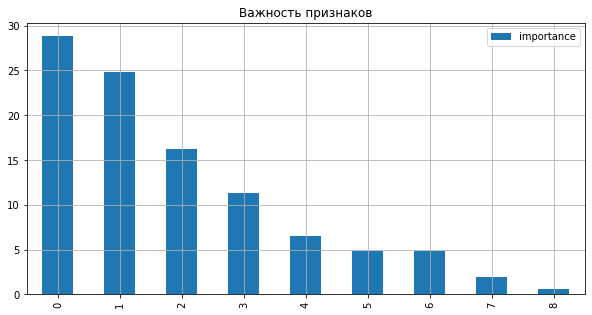

In [625]:
importances = cbr_default.feature_importances_
feature_list = list(train_features.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

ax = feature_results.plot(grid=True, kind='bar', title='Важность признаков',  figsize=(10, 5))
feature_results

 <b>Вывод:</b> При тестировании модели CatBoost с гиперпараметрами по умолчанию метрика RMSE не изменилась и составила 1879 что ниже требуемого порога и делает эту модель приемлемой для предложения заказчику.
    
Рапределение признаков по значимости для формирования цены автомобиля  вполне ожидаемо: на первом месте стоит возраст автомобиля, на втором - мощность, на третьем - пробег, на четвертом - модель. Такме признаки как марка автомобиля, тип кузова и топлива, практически равнозначны. Факт ремонта автомобиля и тип коробки передач определяют цену в последнюю очередь.
    

 <b>  Итоговый вывод:</b>

По заказу сервиса по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывающего приложение для привлечения новых клиентов нами построены несколько моделей машинного обучения, предсказывающих рыночную стоимость автомобиля. Для построения моделей использованы предоставленные заказчиком исторические данные: технические характеристики, комплектации и цены автомобилей.
    
В ходе предварительной обработки данных мы устранили аномальные значения в столбцах 'Price', 'RegistrationYear' и 'Power', пропущенные значения  в столбцах 'VehicleType' и 'FuelType' заменили на типы, используемые в большинстве случаев каждой конкретной моделью автомобиля, пропуски в столбцах  'Repaired' и 'Gearbox', имеющих бинарные значения,  заменены на значения, представленные в большинстве, пропуски по столбцу 'Model' заменены на 'unknown'.  
    
Изучением корреляции количественных признаков установлена логичная положительная корреляция между ценой и мощьностью автомобиля и отрицательная корреляция между ценой и пробегом автомобиля.    
    
В стадии подготовки признаков для построения моделей категоризированы признаки 'RegistrationYear','Gearbox' и 'Repaired', техникой целевого кодирования закодированы признаки 'VehicleType', 'Model','FuelType','Brand', посредством модуля StandardScaler стандартизированы признаки 'Power', 'Kilometer'.

Для построения моделей данные разделены на учебную, валидационную и тестовую выборки в соотношении 3:1:1.     


Критерии оценки модели, определенные заказчиком, являются качество предсказания, скорость предсказания и время обучения. Для оценки качества моделей условием проекта определена метрика RMSE, значение которой должно быть меньше 2500.
    
В соответствии с условием проекта мы построили несколько моделей, предсказывающих рыночную стоимость автомобиля:Случайный лес и Дерево решений (при гиперпараметрах по умолчанию и с подборкой гиперпараметров с использованием GridSearchCV по каждой модели), модели градиентного бустинга LightGBM также с гиперпараметрами по умолчанию и их подбором GridSearchCV, модели градиентного бустинга CatBoost с гиперпараметрами по умолчанию на преобразованных признаках и с передачей категориальных признаков в исходном состоянии.
    
Метрика RMSE всех моделей, полученная на предсказаниях валидационной выборки, значительно ниже установленного заказчиком порога 2500. Однако скорость обучения и предсказаний значительно разнится. 

Самая низкая метрика RMSE (1812) у модели Случайный лес, построенной при гиперпараметрах по умолчанию. Но у этой же модели самая низкая скорость обучения и получения предсказаний в связи с чем она исключена из тестирования.
    
Самая высокая скорость обучения у моделей градиентного бустинга LightGBM, однако RMSE этих моделей на уровне среднего значения по сравнению с другими моделями.

На втором месте по значению RMSE (1879) у модели градиентного бустинга CatBoost с гиперпараметрами по умолчанию. Скорость обучения у данной модели более чем в два раза выше Случайного леса в связи с чем она выбрана для тестирования на тестовой выборке.
    
При тестировании метрика RMSE не изменилась.  
    
С учетом приемлемой скорости обучения заказчику возможно предложить модель градиентного бустинга CatBoost с гиперпараметрами по умолчанию.    